## LAN Traffic Classification Using Machine Learning

This notebook implements a machine learning pipeline for classifying network traffic types based on packet-level features extracted from network flows.

### Objectives:
1. **Data Loading & Integration**: Combine multiple network traffic datasets
2. **Feature Engineering and Prepocessing**: Extract and transform network flow features
3. **Exploratory Data Analysis**: Understand data patterns, distributions, and relationships
4. **Model Training**: Build classification models to identify traffic types
5. **Evaluation**: Assess model performance and feature importance

### Dataset Sources:
- VPN/Proxy Traffic
- Normal Ethernet Traffic
- Router Traffic(Multiple Devices via same connections)

### Key Features:
- Packet-level statistics (count, length, rate)
- Flow characteristics (duration, byte count)
- TCP flags (SYN, ACK, FIN, RST, PSH, URG)
- Protocol information
- IP addresses (source and destination)

### Target Variable:
- **Type**: Classification of traffic (Normal, VPN, etc.)

---
# 1. Data Loading & Preparation

Loading multiple network traffic CSV files and combining them into a single dataset.

In [1]:
import pandas as pd
import numpy as np

path1 = "C:/Users/aakas/Downloads/data/warp_traffic.csv"
path2 = "C:/Users/aakas/Downloads/data/normal_traffic.csv"
path3 = "C:/Users/aakas/Downloads/data/phone-hotspot.csv"
path4 = "C:/Users/aakas/Downloads/data/normal-ethernet.csv"

address = [path1, path2, path3, path4]

dfs = []          
for add in address:
    df = pd.read_csv(add, encoding='latin-1')
    dfs.append(df)

combined = pd.concat(dfs, ignore_index=True)

In [2]:
combined = combined.dropna()
combined.describe()

,No.,Time,Length
count,976774.000000,976774.000000,976774.000000
mean,164178.887872,1225.699459,901.095123
std,117206.836018,1087.344932,814.654350
min,1.000000,0.000000,12.000000
25%,66857.000000,207.123595,66.000000
50%,134676.000000,757.939977,1354.000000
75%,258058.750000,2427.219061,1514.000000
max,422744.000000,3435.555193,13194.000000


In [3]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 976774 entries, 0 to 1118241
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   No.          976774 non-null  int64  
 1   Time         976774 non-null  float64
 2   Source       976774 non-null  object 
 3   Destination  976774 non-null  object 
 4   Protocol     976774 non-null  object 
 5   Length       976774 non-null  int64  
 6   Info         976774 non-null  object 
 7   Type         976774 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 67.1+ MB


In [4]:
print(combined['Protocol'].value_counts())

Protocol
TCP         541574
ISAKMP      180198
TLSv1.3      80843
ARP          51609
MDNS         30025
             ...  
0x6694           1
0x893c           1
0x66dd           1
HTTP/XML         1
0x5243           1
Name: count, Length: 108, dtype: int64


In [5]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

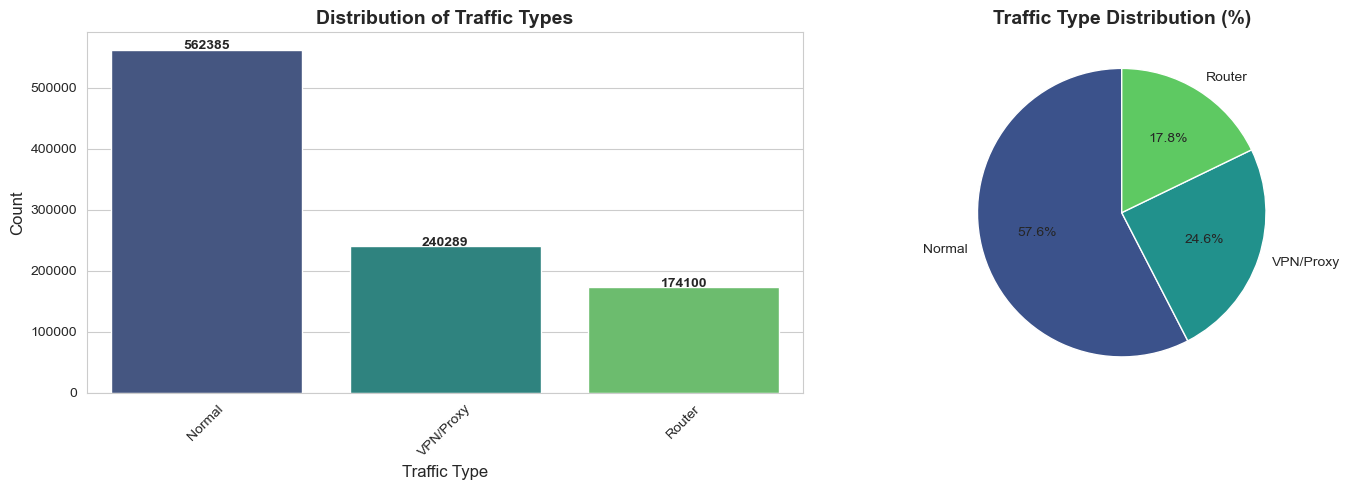


Class Distribution:
Type
Normal       562385
VPN/Proxy    240289
Router       174100
Name: count, dtype: int64

Class Balance Ratio: 30.96%


In [6]:
# Distribution of target variable
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Count plot
type_counts = combined['Type'].value_counts()
sns.barplot(x=type_counts.index, y=type_counts.values, ax=axes[0], palette='viridis')
axes[0].set_title('Distribution of Traffic Types', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Traffic Type', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Add value labels on bars
for i, v in enumerate(type_counts.values):
    axes[0].text(i, v + 100, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=sns.color_palette('viridis', len(type_counts)))
axes[1].set_title('Traffic Type Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nClass Distribution:")
print(type_counts)
print(f"\nClass Balance Ratio: {type_counts.min() / type_counts.max():.2%}")

---
# 2. Feature Engineering and Preprocessing

Transforming raw packet data into meaningful features for machine learning.

In [7]:
import pandas as pd
import numpy as np
import re
from typing import Tuple

# Configuration
# Columns expected from Wireshark CSV export:
# Time, Source, Destination, Protocol, Length, Info
TIME_COL = "Time"
SRC_COL = "Source"
DST_COL = "Destination"
PROTO_COL = "Protocol"
LEN_COL = "Length"
INFO_COL = "Info"
TYPE_COL = "Type"

ONE_HOT_PROTOCOLS = True


# Regex patterns for parsing the Info column (TCP/UDP-like formats)

TCP_UDP_INFO_RE = re.compile(
    r"""
    ^\s*
    (?P<src_port>\d+)\s*>\s*(?P<dst_port>\d+)      # ports: 60582 > 443
    (?:\s*\[(?P<flags>[^\]]+)\])?                  # flags: [ACK], [SYN, ACK], ...
    (?:.*?Seq=(?P<seq>\d+))?                       # Seq=1
    (?:.*?Ack=(?P<ack>\d+))?                       # Ack=1
    (?:.*?Win=(?P<win>\d+))?                       # Win=254
    (?:.*?Len=(?P<len>\d+))?                       # Len=1
    """,
    re.VERBOSE,
)

ARP_INFO_RE = re.compile(
    r"""
    \b(?P<who_has>Who\ has)\s+(?P<target_ip>\d+\.\d+\.\d+\.\d+)\?
    \s+Tell\s+(?P<src_ip>\d+\.\d+\.\d+\.\d+)
    """,
    re.VERBOSE,
)



# Parsing helpers

def parse_tcp_udp_info(info: str) -> dict:
    """
    Parse TCP/UDP-style Info column from Wireshark into a feature dict.

    Returns keys:
        src_port, dst_port, tcp_flag_syn, tcp_flag_ack, tcp_flag_fin,
        tcp_flag_rst, tcp_flag_psh, tcp_flag_urg,
        tcp_seq, tcp_ack, tcp_win, tcp_payload_len
    Missing values are returned as np.nan or 0 where appropriate.
    """
    m = TCP_UDP_INFO_RE.search(info or "")
    features = {
        "src_port": np.nan,
        "dst_port": np.nan,
        "tcp_flag_syn": 0,
        "tcp_flag_ack": 0,
        "tcp_flag_fin": 0,
        "tcp_flag_rst": 0,
        "tcp_flag_psh": 0,
        "tcp_flag_urg": 0,
        "tcp_seq": np.nan,
        "tcp_ack": np.nan,
        "tcp_win": np.nan,
        "tcp_payload_len": np.nan,
    }

    if not m:
        return features

    # Basic ports
    try:
        features["src_port"] = int(m.group("src_port"))
    except (ValueError, TypeError):
        pass

    try:
        features["dst_port"] = int(m.group("dst_port"))
    except (ValueError, TypeError):
        pass

    # Flags
    flags_str = m.group("flags") or ""
    flags_str = flags_str.upper()
    if "SYN" in flags_str:
        features["tcp_flag_syn"] = 1
    if "ACK" in flags_str:
        features["tcp_flag_ack"] = 1
    if "FIN" in flags_str:
        features["tcp_flag_fin"] = 1
    if "RST" in flags_str:
        features["tcp_flag_rst"] = 1
    if "PSH" in flags_str:
        features["tcp_flag_psh"] = 1
    if "URG" in flags_str:
        features["tcp_flag_urg"] = 1

    # Seq, Ack, Win, Len
    for key, group_name in [
        ("tcp_seq", "seq"),
        ("tcp_ack", "ack"),
        ("tcp_win", "win"),
        ("tcp_payload_len", "len"),
    ]:
        val_str = m.group(group_name)
        if val_str is not None:
            try:
                features[key] = int(val_str)
            except ValueError:
                pass

    return features


def parse_arp_info(info: str) -> dict:
    """
    Parse ARP Info into a few simple features.
    This is very lightweight but gives you something for ARP rows.
    """
    m = ARP_INFO_RE.search(info or "")
    features = {
        "arp_is_request": 0,
        "arp_is_reply": 0,
    }

    if "Request" in (info or "") or "Who has" in (info or ""):
        features["arp_is_request"] = 1
    if "Reply" in (info or ""):
        features["arp_is_reply"] = 1

    # Could also add target IP, src IP, etc., if desired.
    return features


def parse_info_row(protocol: str, info: str) -> dict:
    """
    Dispatch parsing based on protocol.
    TCP, UDP, QUIC, TLS will all reuse TCP_UDP_INFO_RE pattern as they tend
    to share the "src_port > dst_port [FLAGS] ..." structure in the Info column.
    """
    proto = (protocol or "").upper()

    # Base feature dict
    base_features = {
        # TCP/UDP-style
        "src_port": np.nan,
        "dst_port": np.nan,
        "tcp_flag_syn": 0,
        "tcp_flag_ack": 0,
        "tcp_flag_fin": 0,
        "tcp_flag_rst": 0,
        "tcp_flag_psh": 0,
        "tcp_flag_urg": 0,
        "tcp_seq": np.nan,
        "tcp_ack": np.nan,
        "tcp_win": np.nan,
        "tcp_payload_len": np.nan,
        # ARP-style
        "arp_is_request": 0,
        "arp_is_reply": 0,
    }

    if proto in {"TCP", "UDP", "QUIC", "TLS"}:
        parsed = parse_tcp_udp_info(info)
        base_features.update(parsed)
    elif proto == "ARP":
        parsed = parse_arp_info(info)
        base_features.update(parsed)
    else:
        # Unknown/other protocol; keep defaults
        pass

    return base_features


# Flow key and aggregation

def compute_flow_key(df: pd.DataFrame) -> pd.Series:
    """
    Build a simple 5-tuple flow key using source, destination, protocol,
    src_port, dst_port.

    Assumes src_port and dst_port columns already exist.
    """
    # Ensure ports exist; fillna to -1 to keep as ints
    src_port = df["src_port"].fillna(-1).astype(int).astype(str)
    dst_port = df["dst_port"].fillna(-1).astype(int).astype(str)

    key = (
        df[SRC_COL].astype(str)
        + "|"
        + df[DST_COL].astype(str)
        + "|"
        + df[PROTO_COL].astype(str)
        + "|"
        + src_port
        + "|"
        + dst_port
    )
    return key


def aggregate_flows(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Time normalization
    if np.issubdtype(df[TIME_COL].dtype, np.datetime64):
        t0 = df[TIME_COL].min()
        df["_ts"] = (df[TIME_COL] - t0).dt.total_seconds()
    else:
        df["_ts"] = pd.to_numeric(df[TIME_COL], errors="coerce")

    df["_len"] = pd.to_numeric(df[LEN_COL], errors="coerce")

    # Build flow key
    df["flow_id"] = compute_flow_key(df)

    group = df.groupby("flow_id", dropna=False)

    # Base aggregation dictionary
    agg_dict = dict(
        src_ip=(SRC_COL, "first"),
        dst_ip=(DST_COL, "first"),
        protocol=(PROTO_COL, "first"),
        src_port=("src_port", "first"),
        dst_port=("dst_port", "first"),
        packet_count=("_len", "count"),
        byte_count=("_len", "sum"),
        avg_packet_len=("_len", "mean"),
        std_packet_len=("_len", "std"),
        min_packet_len=("_len", "min"),
        max_packet_len=("_len", "max"),
        first_ts=("_ts", "min"),
        last_ts=("_ts", "max"),
        syn_count=("tcp_flag_syn", "sum"),
        ack_count=("tcp_flag_ack", "sum"),
        fin_count=("tcp_flag_fin", "sum"),
        rst_count=("tcp_flag_rst", "sum"),
        psh_count=("tcp_flag_psh", "sum"),
        urg_count=("tcp_flag_urg", "sum"),
        avg_payload_len=("tcp_payload_len", "mean"),
        std_payload_len=("tcp_payload_len", "std"),
        # dns_query_count=("dns_is_query", "sum"),
        # dns_response_count=("dns_is_response", "sum"),
        # dhcp_count=("dhcp_msg_request", "sum"),
        # http_request_count=("http_is_request", "sum"),
        # http_response_count=("http_is_response", "sum"),
        # icmp_echo_req_count=("icmp_is_echo_request", "sum"),
        # icmp_echo_rep_count=("icmp_is_echo_reply", "sum"),
        # igmp_query_count=("igmp_is_query", "sum"),
        # igmp_report_count=("igmp_is_report", "sum"),
    )

    # If Type column exists, keep it as a flow-level label
    if TYPE_COL in df.columns:
        agg_dict["type"] = (TYPE_COL, "first")  # or use mode if you prefer

    flow_features = group.agg(**agg_dict)

    flow_features["flow_duration"] = (
        flow_features["last_ts"] - flow_features["first_ts"]
    )
    flow_features["packet_rate"] = (
        flow_features["packet_count"] /
        flow_features["flow_duration"].replace(0, np.nan)
    )

    for flag, col in [
        ("syn_ratio", "syn_count"),
        ("ack_ratio", "ack_count"),
        ("fin_ratio", "fin_count"),
        ("rst_ratio", "rst_count"),
    ]:
        flow_features[flag] = (
            flow_features[col] /
            flow_features["packet_count"].replace(0, np.nan)
        )

    flow_features = flow_features.replace([np.inf, -np.inf], np.nan)
    return flow_features.reset_index(drop=False)


def load_and_parse_packets(df: str) -> pd.DataFrame:
    """
    Load Wireshark DF and add parsed packet-level features.

    Returns a DataFrame where each row is a packet with added columns:
        src_port, dst_port, tcp_flag_*, tcp_seq, tcp_ack,
        tcp_win, tcp_payload_len, arp_is_request, arp_is_reply,
        and (optionally) protocol one-hot columns.
    """

    # Parse Info column row-by-row
    parsed_rows = df[[PROTO_COL, INFO_COL]].apply(
        lambda row: parse_info_row(row[PROTO_COL], row[INFO_COL]), axis=1
    )

    parsed_df = pd.DataFrame(list(parsed_rows))
    df = pd.concat([df, parsed_df], axis=1)

    # One-hot encode protocol if desired
    if ONE_HOT_PROTOCOLS:
        proto_dummies = pd.get_dummies(df[PROTO_COL], prefix="proto")
        df = pd.concat([df, proto_dummies], axis=1)

    return df


def build_flow_feature_frame(df: str) -> pd.DataFrame:
    """
    High-level helper:
    1. Load CSV
    2. Parse Info
    3. Aggregate by flow into flow-level features

    Returns a DataFrame suitable for feeding into a classifier.
    """
    packet_df = load_and_parse_packets(df)
    flow_df = aggregate_flows(packet_df)
    return flow_df


flow_features = build_flow_feature_frame(combined)

flow_features.describe()


,src_port,dst_port,packet_count,byte_count,avg_packet_len,std_packet_len,min_packet_len,max_packet_len,first_ts,last_ts,...,psh_count,urg_count,avg_payload_len,std_payload_len,flow_duration,packet_rate,syn_ratio,ack_ratio,fin_ratio,rst_ratio
count,35516.000000,35516.000000,39831.000000,3.983100e+04,38212.000000,20835.000000,38212.000000,38212.000000,38212.000000,38212.000000,...,39831.000000,39831.000000,35510.000000,18813.000000,38212.000000,20527.000000,38212.000000,38212.000000,38212.000000,38212.000000
mean,27068.390810,29289.165644,24.522960,2.209752e+04,409.943447,114.551815,343.928033,499.924893,1115.631429,1226.861434,...,1.047978,0.000075,488.163562,140.178138,111.230005,1157.409221,0.049346,0.819807,0.051533,0.005971
std,28119.929894,28168.930162,638.021962,7.635286e+05,532.485848,233.608512,509.944263,642.283582,956.345227,992.672980,...,18.437913,0.008678,704.984119,321.096189,375.894315,10931.548985,0.189957,0.376688,0.201999,0.068569
min,1.000000,6.000000,0.000000,0.000000e+00,12.000000,0.000000,12.000000,12.000000,0.000000,0.006314,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000653,0.000000,0.000000,0.000000,0.000000
25%,443.000000,443.000000,1.000000,8.600000e+01,62.333333,0.000000,60.000000,66.000000,144.567929,197.751717,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.059202,0.000000,1.000000,0.000000,0.000000
50%,7680.000000,20562.000000,2.000000,2.700000e+02,107.000000,0.000000,86.000000,110.000000,1080.351860,1151.097827,...,0.000000,0.000000,0.000000,0.000000,0.001979,1.058919,0.000000,1.000000,0.000000,0.000000
75%,57492.000000,58418.250000,4.000000,1.514000e+03,516.590461,87.827187,225.000000,1254.250000,1647.478719,1757.794007,...,0.000000,0.000000,1412.000000,0.000000,8.011414,17.386265,0.000000,1.000000,0.000000,0.000000
max,65509.000000,65509.000000,95702.000000,1.183371e+08,2974.000000,2836.679043,2974.000000,13194.000000,3433.991981,3435.555193,...,1910.000000,1.000000,24668.000000,14188.960216,3435.012429,500000.001262,1.000000,1.000000,1.000000,1.000000


# 3. Exploratory Data Analysis (EDA)

This section explores the data visually to understand:
- Distribution of target variable ('type')
- Feature correlations
- Feature importance for classification
- Missing values patterns
- Relationships between key features and target

In [8]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## 3.1. Type Distribution

Distribution of our target variable ('type') after converting packet data into network flows.

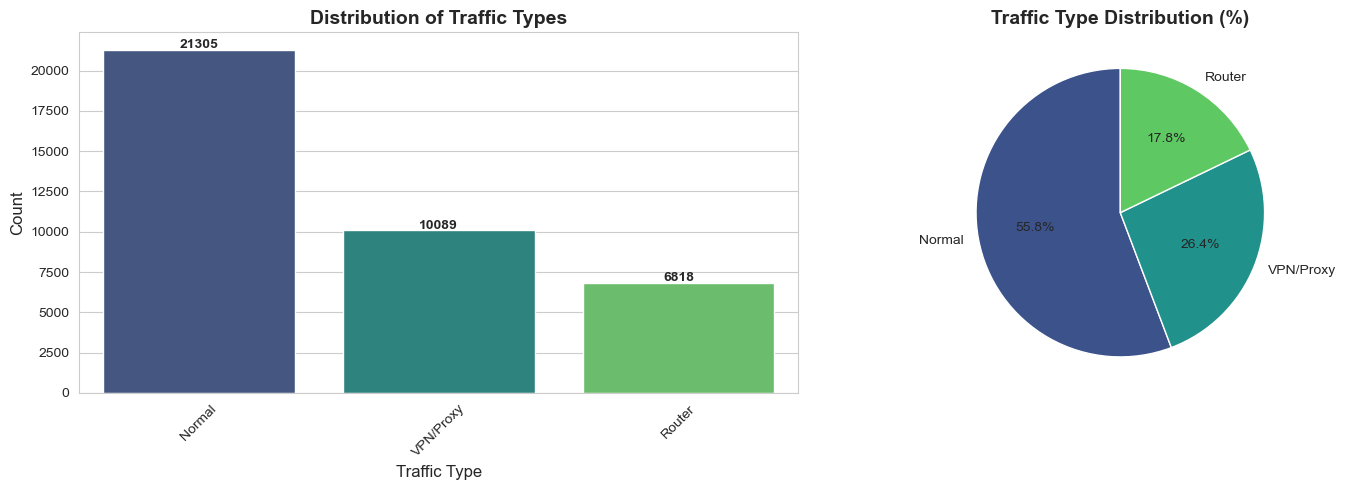


Class Distribution:
type
Normal       21305
VPN/Proxy    10089
Router        6818
Name: count, dtype: int64

Class Balance Ratio: 32.00%


In [9]:
# Distribution of target variable
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Count plot
type_counts = flow_features['type'].value_counts()
sns.barplot(x=type_counts.index, y=type_counts.values, ax=axes[0], palette='viridis')
axes[0].set_title('Distribution of Traffic Types', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Traffic Type', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Add value labels on bars
for i, v in enumerate(type_counts.values):
    axes[0].text(i, v + 100, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=sns.color_palette('viridis', len(type_counts)))
axes[1].set_title('Traffic Type Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nClass Distribution:")
print(type_counts)
print(f"\nClass Balance Ratio: {type_counts.min() / type_counts.max():.2%}")

## 3.2. Missing Values Analysis

Identifying missing data patterns helps in preprocessing decisions.

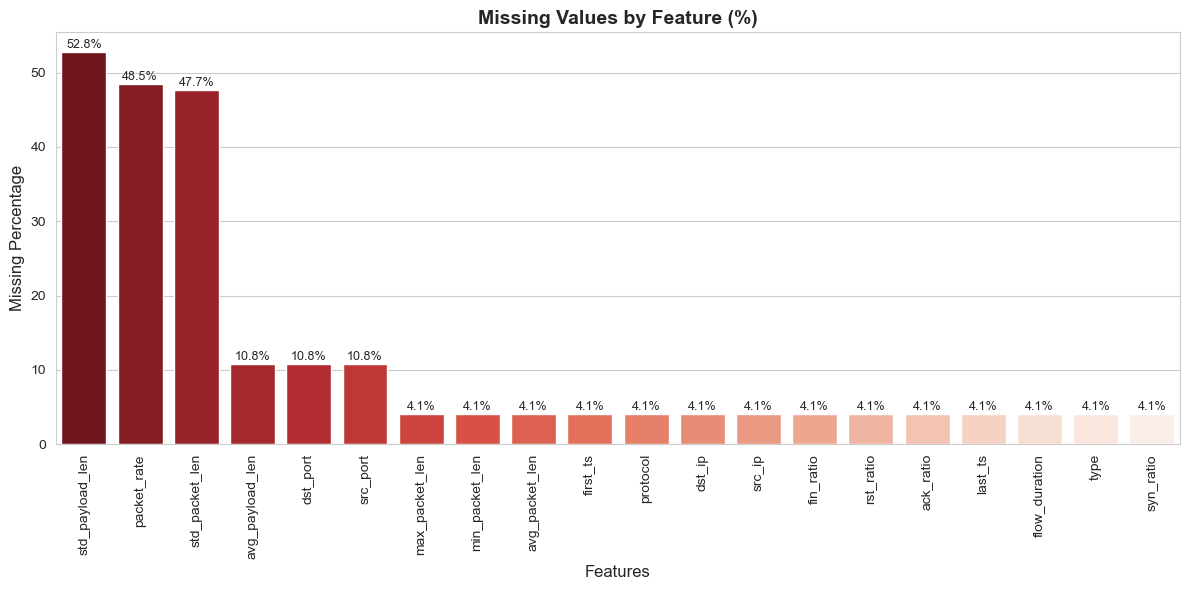


Top features with missing values:
                 Missing_Count  Percentage
std_payload_len          21018   52.767945
packet_rate              19304   48.464764
std_packet_len           18996   47.691497
avg_payload_len           4321   10.848334
dst_port                  4315   10.833271
src_port                  4315   10.833271
max_packet_len            1619    4.064673
min_packet_len            1619    4.064673
avg_packet_len            1619    4.064673
first_ts                  1619    4.064673


In [10]:
# Missing values analysis
missing_data = flow_features.isnull().sum()
missing_percent = (missing_data / len(flow_features)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_data,
    'Percentage': missing_percent
}).sort_values('Percentage', ascending=False)

# Plot only columns with missing values
missing_cols = missing_df[missing_df['Missing_Count'] > 0]

if len(missing_cols) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(x=missing_cols.index, y=missing_cols['Percentage'], palette='Reds_r', ax=ax)
    ax.set_title('Missing Values by Feature (%)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Missing Percentage', fontsize=12)
    ax.tick_params(axis='x', rotation=90)
    
    # Add value labels
    for i, v in enumerate(missing_cols['Percentage']):
        ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print("\nTop features with missing values:")
    print(missing_cols.head(10))
else:
    print("No missing values found in the dataset!")

## 3.3. Feature Correlation Analysis

Correlation heatmap shows relationships between numerical features. 
High correlations may indicate redundant features or multicollinearity.

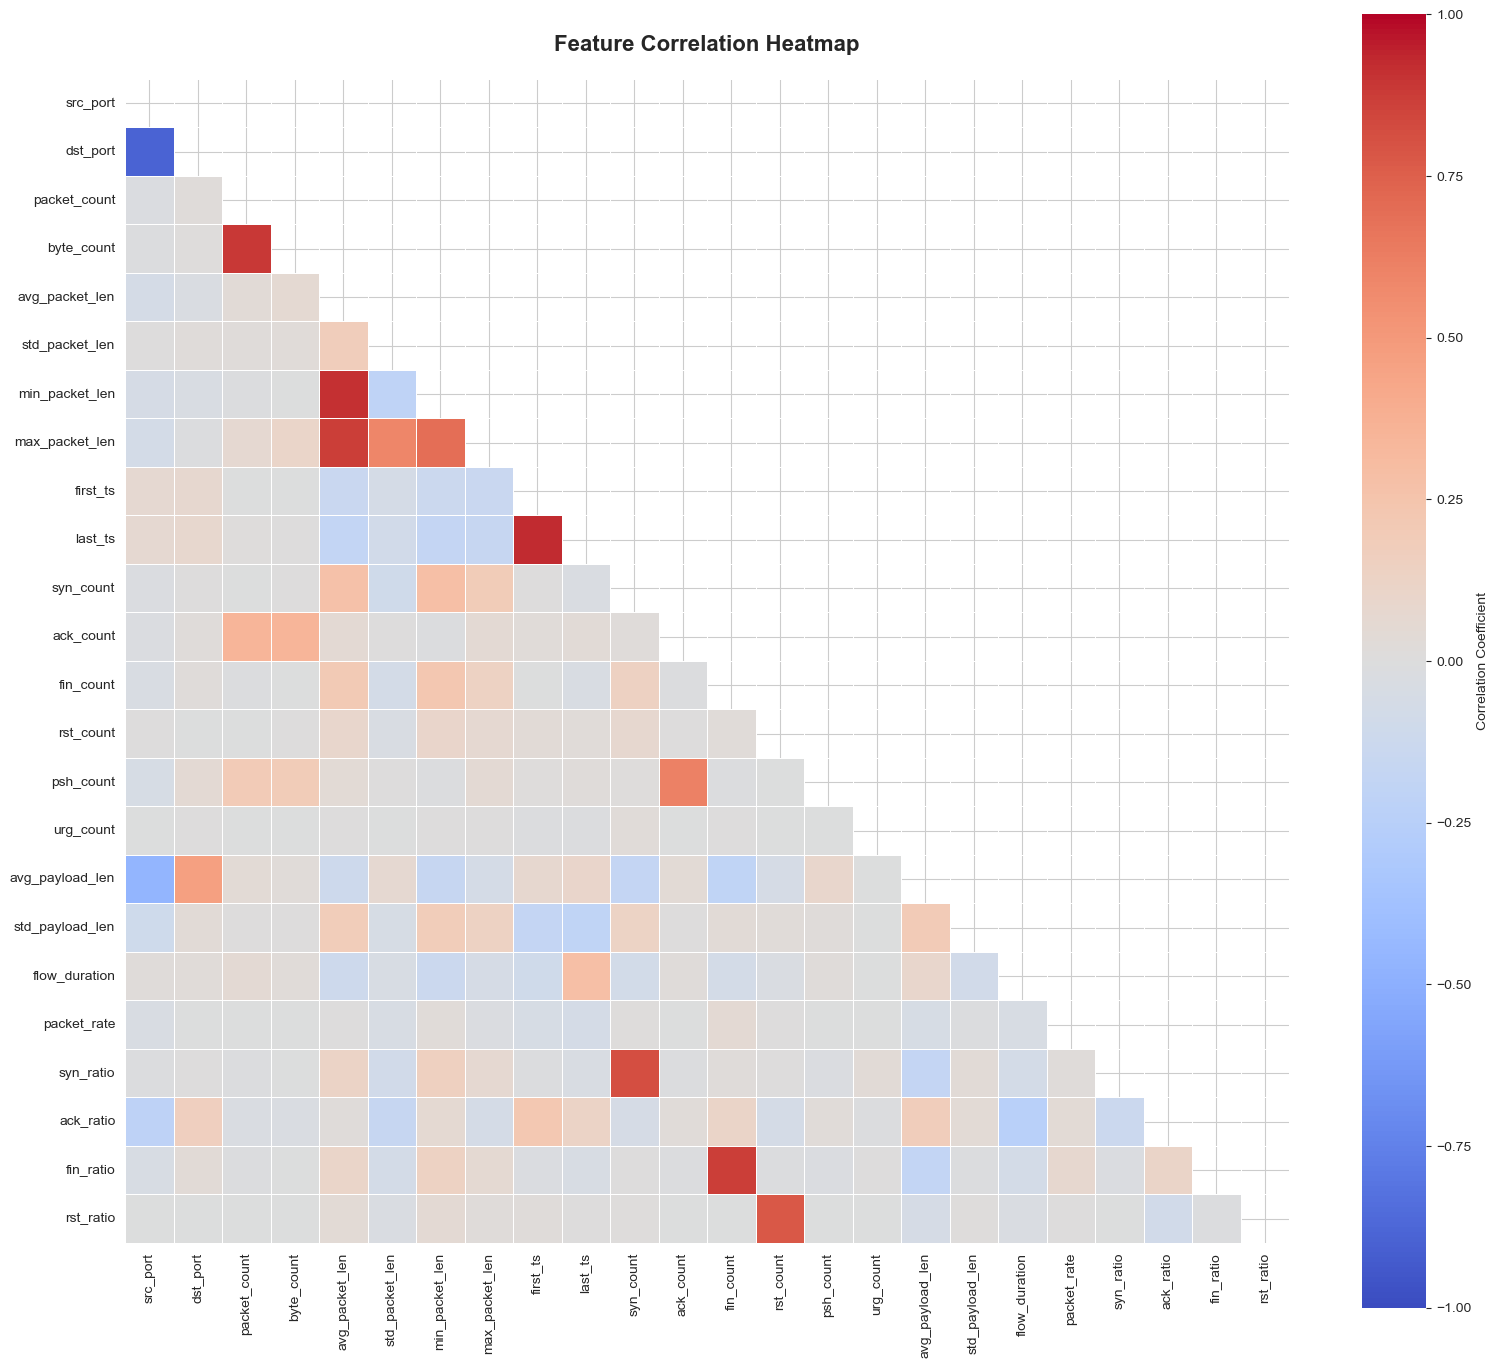


Highly Correlated Feature Pairs (|r| > 0.8):
first_ts <-> last_ts: 0.926
avg_packet_len <-> min_packet_len: 0.913
src_port <-> dst_port: -0.892
packet_count <-> byte_count: 0.888
fin_count <-> fin_ratio: 0.870
avg_packet_len <-> max_packet_len: 0.869
syn_count <-> syn_ratio: 0.815


In [11]:
# Select only numeric columns for correlation
numeric_cols = flow_features.select_dtypes(include=[np.number]).columns.tolist()

# Remove 'No.' and 'Time' if they exist as they're just indices
cols_to_remove = ['No.', 'Time', 'No', 'Time']
numeric_cols = [col for col in numeric_cols if col not in cols_to_remove]

# Calculate correlation matrix
correlation_matrix = flow_features[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, square=True, linewidths=0.5,
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Find highly correlated feature pairs
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    print("\nHighly Correlated Feature Pairs (|r| > 0.8):")
    for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:10]:
        print(f"{feat1} <-> {feat2}: {corr:.3f}")
else:
    print("\nNo highly correlated feature pairs found (|r| > 0.8)")

## 3.4. Distribution of Key Numerical Features

Understanding the distribution of important features helps identify:
- Skewness and outliers
- Need for normalization/scaling
- Data quality issues

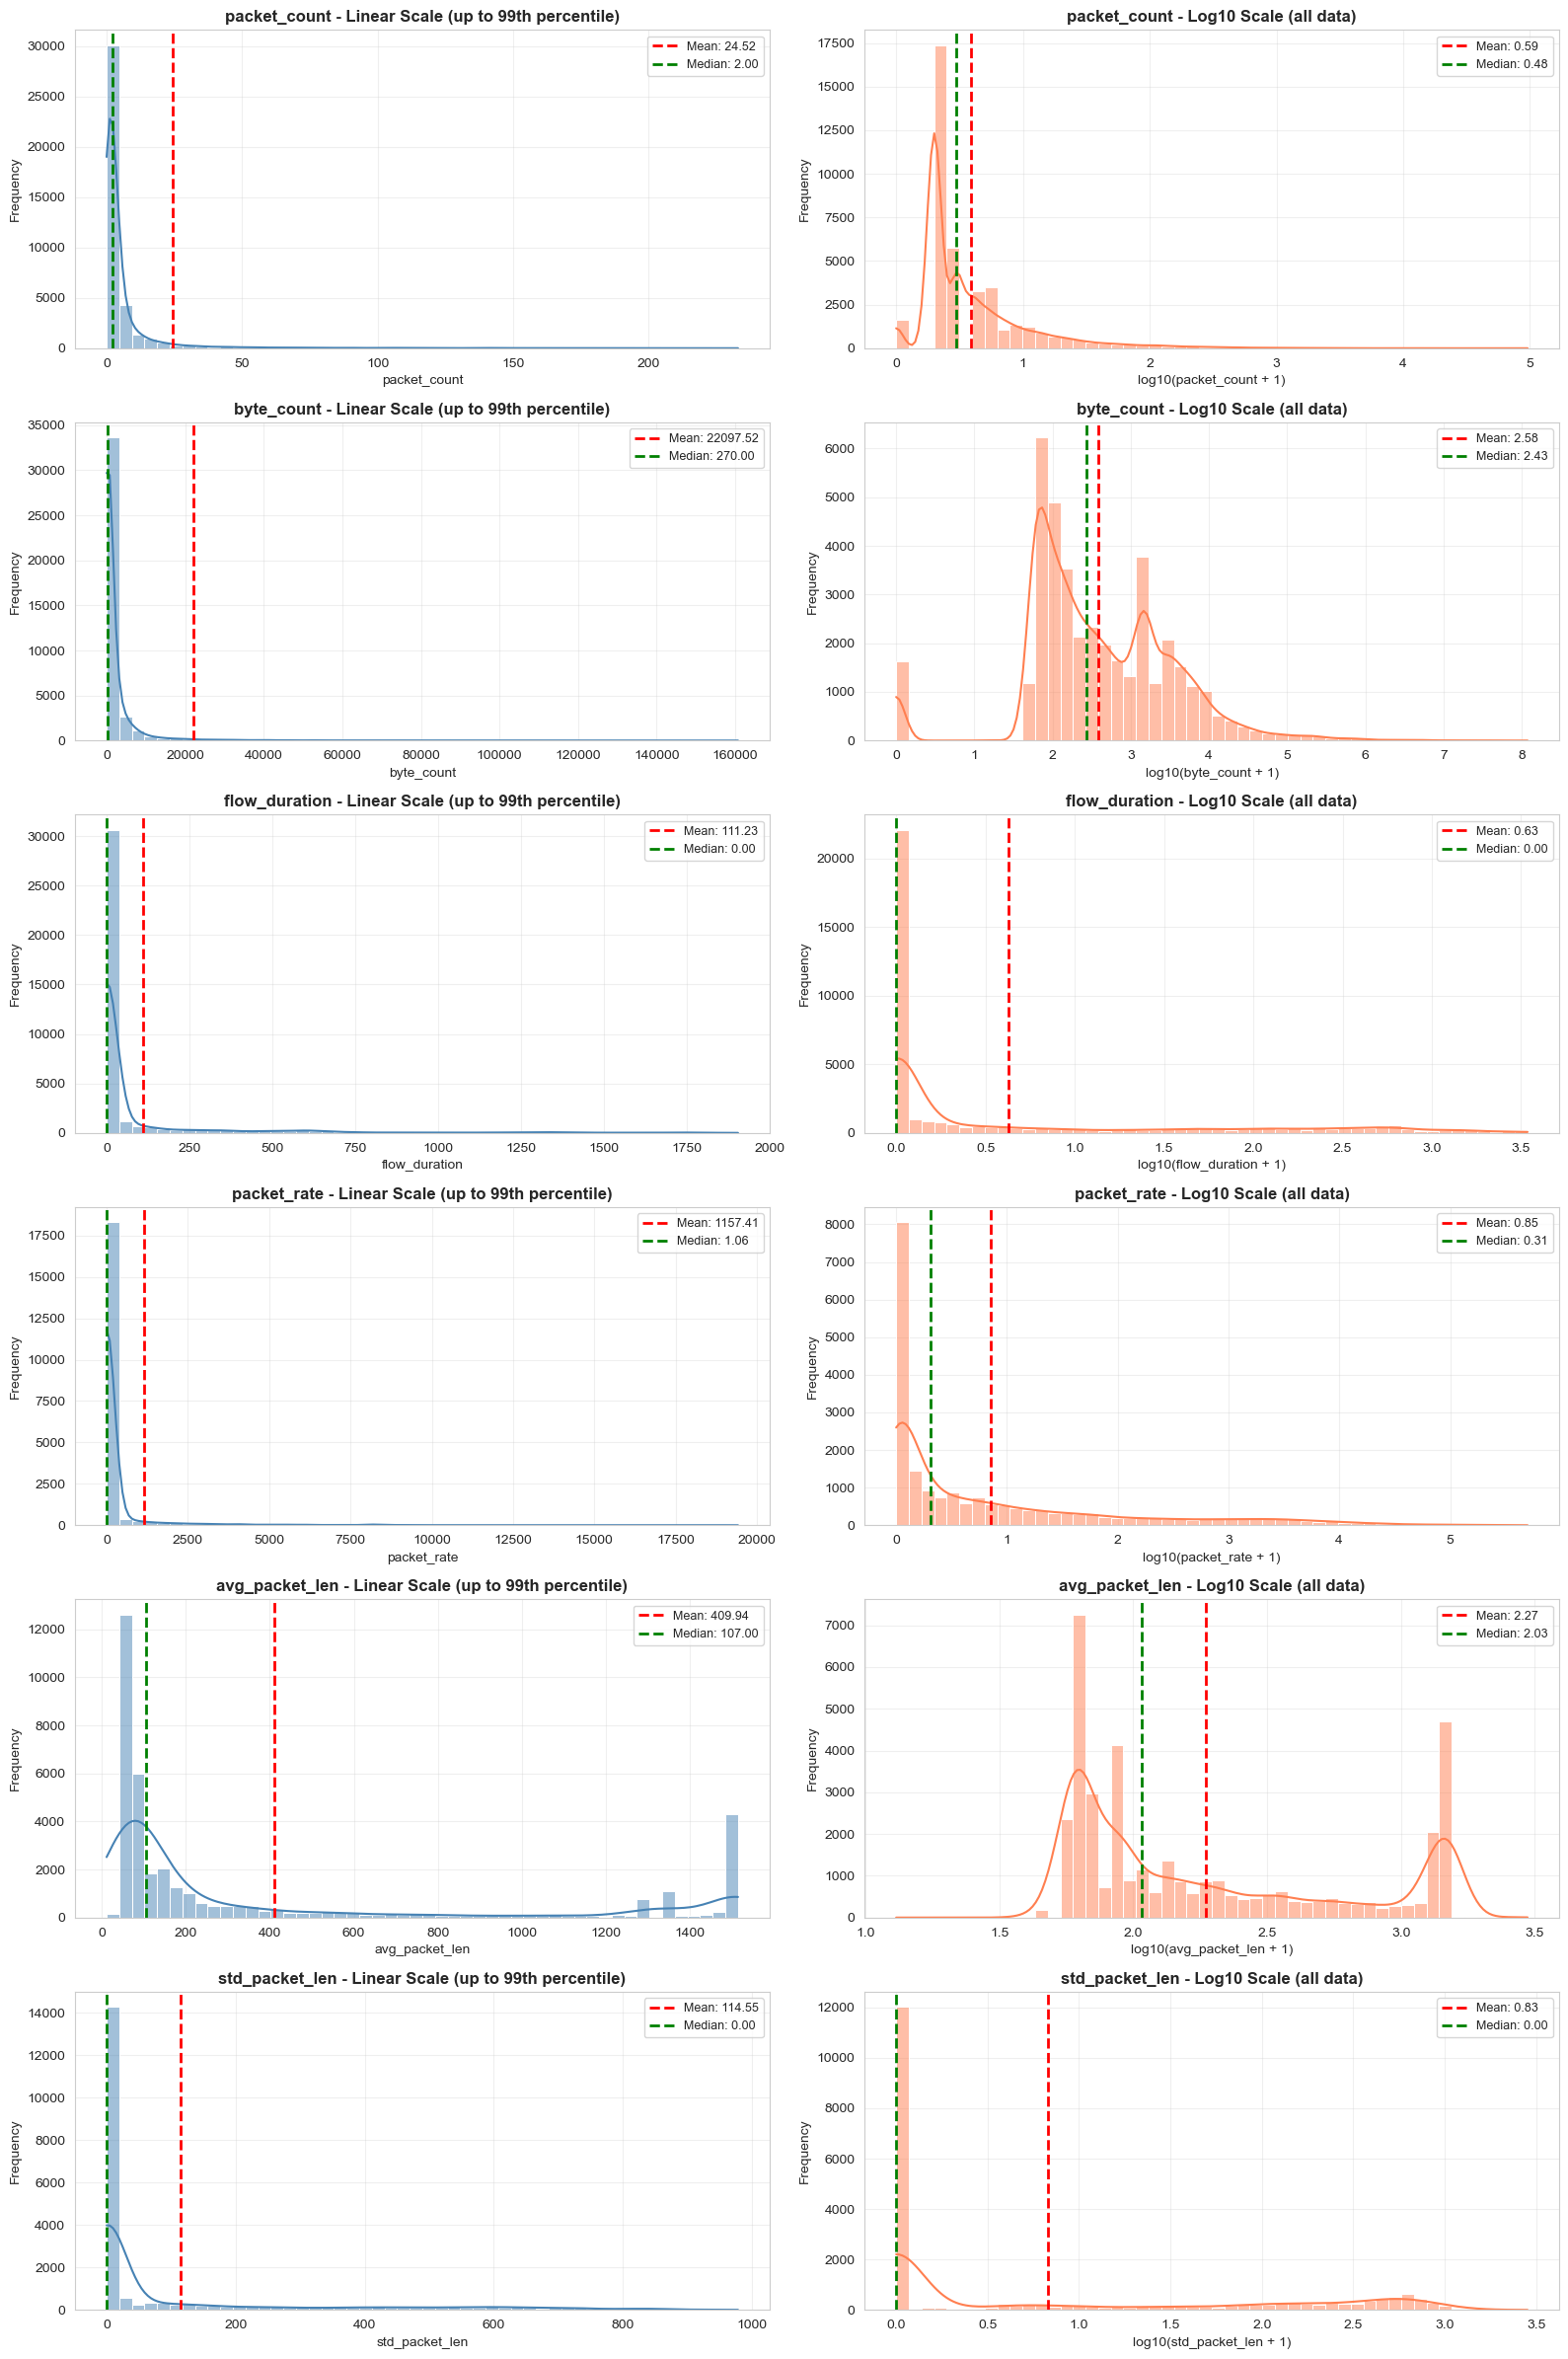


FEATURE STATISTICS SUMMARY

packet_count:
  Count: 39,831
  Mean: 24.52
  Median: 2.00
  Std: 638.02
  Min: 0.00
  Max: 95702.00
  Skewness: 105.52
  99th percentile: 233.00

byte_count:
  Count: 39,831
  Mean: 22097.52
  Median: 270.00
  Std: 763528.63
  Min: 0.00
  Max: 118337144.00
  Skewness: 107.53
  99th percentile: 160833.60

flow_duration:
  Count: 38,212
  Mean: 111.23
  Median: 0.00
  Std: 375.89
  Min: 0.00
  Max: 3435.01
  Skewness: 5.35
  99th percentile: 1905.64

packet_rate:
  Count: 20,527
  Mean: 1157.41
  Median: 1.06
  Std: 10931.55
  Min: 0.00
  Max: 500000.00
  Skewness: 21.08
  99th percentile: 19558.35

avg_packet_len:
  Count: 38,212
  Mean: 409.94
  Median: 107.00
  Std: 532.49
  Min: 12.00
  Max: 2974.00
  Skewness: 1.34
  99th percentile: 1514.00

std_packet_len:
  Count: 20,835
  Mean: 114.55
  Median: 0.00
  Std: 233.61
  Min: 0.00
  Max: 2836.68
  Skewness: 2.44
  99th percentile: 978.64


In [12]:
# Select key features for distribution analysis
key_features = ['packet_count', 'byte_count', 'flow_duration', 'packet_rate', 'avg_packet_len', 'std_packet_len']

# Filter to features that actually exist in the dataset
available_features = [f for f in key_features if f in flow_features.columns]

if available_features:
    fig, axes = plt.subplots(len(available_features), 2, figsize=(16, len(available_features)*4))
    if len(available_features) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, feature in enumerate(available_features):
        # Remove outliers for better visualization (keep 99th percentile)
        data_clean = flow_features[feature].dropna()
        q99 = data_clean.quantile(0.99)
        data_viz = data_clean[data_clean <= q99]
        
        # LEFT: Linear scale histogram
        sns.histplot(data_viz, kde=True, ax=axes[idx, 0], 
                    color='steelblue', bins=50)
        axes[idx, 0].set_title(f'{feature} - Linear Scale (up to 99th percentile)', 
                              fontsize=12, fontweight='bold')
        axes[idx, 0].set_xlabel(feature, fontsize=10)
        axes[idx, 0].set_ylabel('Frequency', fontsize=10)
        
        # Add statistics
        mean_val = data_clean.mean()
        median_val = data_clean.median()
        axes[idx, 0].axvline(mean_val, color='red', linestyle='--', linewidth=2, 
                            label=f'Mean: {mean_val:.2f}')
        axes[idx, 0].axvline(median_val, color='green', linestyle='--', linewidth=2, 
                            label=f'Median: {median_val:.2f}')
        axes[idx, 0].legend(fontsize=9)
        axes[idx, 0].grid(True, alpha=0.3)
        
        # RIGHT: Log scale histogram (for highly skewed data)
        # Add small constant to avoid log(0)
        data_log = np.log10(data_clean + 1)
        sns.histplot(data_log, kde=True, ax=axes[idx, 1], 
                    color='coral', bins=50)
        axes[idx, 1].set_title(f'{feature} - Log10 Scale (all data)', 
                              fontsize=12, fontweight='bold')
        axes[idx, 1].set_xlabel(f'log10({feature} + 1)', fontsize=10)
        axes[idx, 1].set_ylabel('Frequency', fontsize=10)
        axes[idx, 1].grid(True, alpha=0.3)
        
        # Add statistics on log scale
        mean_log = data_log.mean()
        median_log = data_log.median()
        axes[idx, 1].axvline(mean_log, color='red', linestyle='--', linewidth=2, 
                            label=f'Mean: {mean_log:.2f}')
        axes[idx, 1].axvline(median_log, color='green', linestyle='--', linewidth=2, 
                            label=f'Median: {median_log:.2f}')
        axes[idx, 1].legend(fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*80)
    print("FEATURE STATISTICS SUMMARY")
    print("="*80)
    for feature in available_features:
        data = flow_features[feature].dropna()
        print(f"\n{feature}:")
        print(f"  Count: {len(data):,}")
        print(f"  Mean: {data.mean():.2f}")
        print(f"  Median: {data.median():.2f}")
        print(f"  Std: {data.std():.2f}")
        print(f"  Min: {data.min():.2f}")
        print(f"  Max: {data.max():.2f}")
        print(f"  Skewness: {data.skew():.2f}")
        print(f"  99th percentile: {data.quantile(0.99):.2f}")
else:
    print("Key features not found in dataset")

## 3.5. Outlier Detection via Boxplots

Boxplots help identify outliers that might affect model performance.

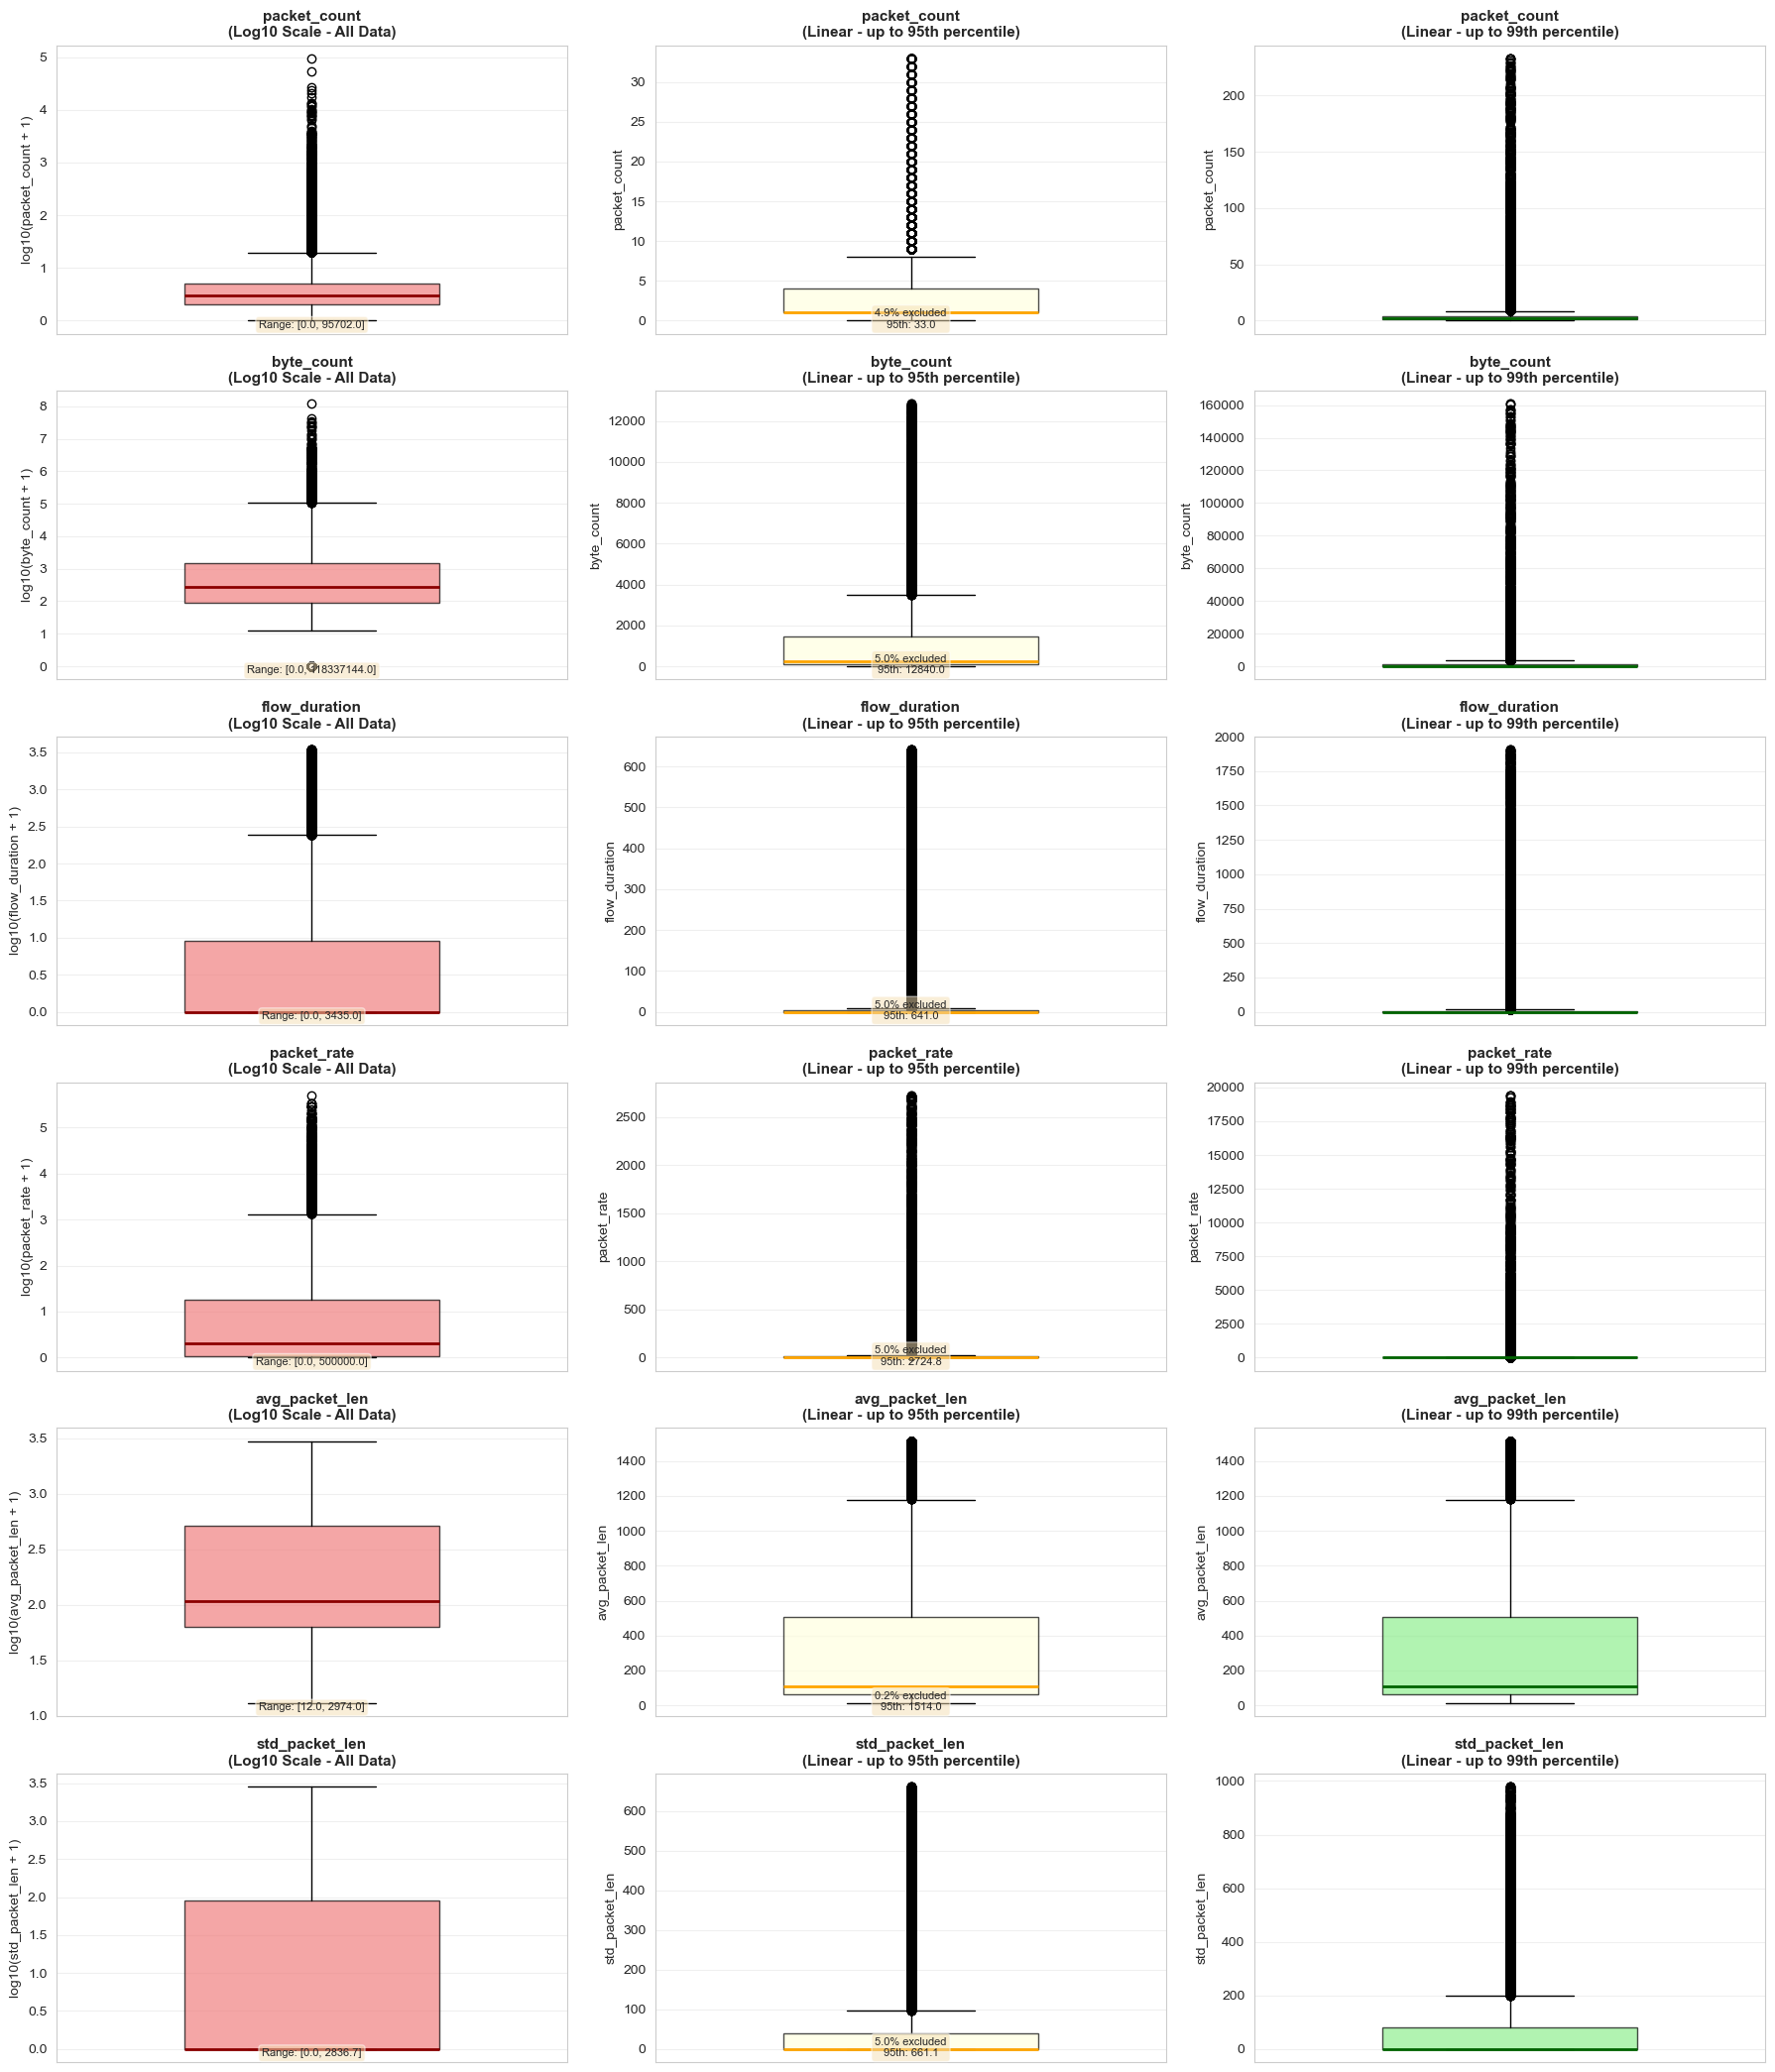


OUTLIER ANALYSIS SUMMARY

packet_count:
  IQR: 3.00
  Lower bound (Q1 - 1.5*IQR): -3.50
  Upper bound (Q3 + 1.5*IQR): 8.50
  Outliers: 5,939 (14.91%)
  Extreme outliers (>99th percentile): 398

byte_count:
  IQR: 1428.00
  Lower bound (Q1 - 1.5*IQR): -2056.00
  Upper bound (Q3 + 1.5*IQR): 3656.00
  Outliers: 5,855 (14.70%)
  Extreme outliers (>99th percentile): 399

flow_duration:
  IQR: 8.01
  Lower bound (Q1 - 1.5*IQR): -12.02
  Upper bound (Q3 + 1.5*IQR): 20.03
  Outliers: 8,457 (22.13%)
  Extreme outliers (>99th percentile): 383

packet_rate:
  IQR: 17.33
  Lower bound (Q1 - 1.5*IQR): -25.93
  Upper bound (Q3 + 1.5*IQR): 43.38
  Outliers: 3,990 (19.44%)
  Extreme outliers (>99th percentile): 206

avg_packet_len:
  IQR: 454.26
  Lower bound (Q1 - 1.5*IQR): -619.05
  Upper bound (Q3 + 1.5*IQR): 1197.98
  Outliers: 6,973 (18.25%)
  Extreme outliers (>99th percentile): 75

std_packet_len:
  IQR: 87.83
  Lower bound (Q1 - 1.5*IQR): -131.74
  Upper bound (Q3 + 1.5*IQR): 219.57
  Outlier

In [13]:
if available_features:
    fig, axes = plt.subplots(len(available_features), 3, figsize=(18, len(available_features)*3.5))
    if len(available_features) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, feature in enumerate(available_features):
        data_all = flow_features[feature].dropna()
        
        # Calculate percentiles
        q95 = data_all.quantile(0.95)
        q99 = data_all.quantile(0.99)
        
        # LEFT: Full data (log scale)
        axes[idx, 0].boxplot(np.log10(data_all + 1), vert=True, widths=0.5,
                            patch_artist=True,
                            boxprops=dict(facecolor='lightcoral', alpha=0.7),
                            medianprops=dict(color='darkred', linewidth=2))
        axes[idx, 0].set_title(f'{feature}\n(Log10 Scale - All Data)', 
                              fontsize=11, fontweight='bold')
        axes[idx, 0].set_ylabel(f'log10({feature} + 1)', fontsize=10)
        axes[idx, 0].grid(True, alpha=0.3, axis='y')
        axes[idx, 0].set_xticks([])
        
        # Add data range info
        axes[idx, 0].text(0.5, 0.02, 
                         f'Range: [{data_all.min():.1f}, {data_all.max():.1f}]',
                         transform=axes[idx, 0].transAxes, ha='center',
                         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                         fontsize=8)
        
        # MIDDLE: Up to 95th percentile
        data_95 = data_all[data_all <= q95]
        axes[idx, 1].boxplot(data_95, vert=True, widths=0.5,
                            patch_artist=True,
                            boxprops=dict(facecolor='lightyellow', alpha=0.7),
                            medianprops=dict(color='orange', linewidth=2))
        axes[idx, 1].set_title(f'{feature}\n(Linear - up to 95th percentile)', 
                              fontsize=11, fontweight='bold')
        axes[idx, 1].set_ylabel(feature, fontsize=10)
        axes[idx, 1].grid(True, alpha=0.3, axis='y')
        axes[idx, 1].set_xticks([])
        
        pct_excluded_95 = ((len(data_all) - len(data_95)) / len(data_all)) * 100
        axes[idx, 1].text(0.5, 0.02, 
                         f'{pct_excluded_95:.1f}% excluded\n95th: {q95:.1f}',
                         transform=axes[idx, 1].transAxes, ha='center',
                         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                         fontsize=8)
        
        # RIGHT: Up to 99th percentile
        data_99 = data_all[data_all <= q99]
        axes[idx, 2].boxplot(data_99, vert=True, widths=0.5,
                            patch_artist=True,
                            boxprops=dict(facecolor='lightgreen', alpha=0.7),
                            medianprops=dict(color='darkgreen', linewidth=2))
        axes[idx, 2].set_title(f'{feature}\n(Linear - up to 99th percentile)', 
                              fontsize=11, fontweight='bold')
        axes[idx, 2].set_ylabel(feature, fontsize=10)
        axes[idx, 2].grid(True, alpha=0.3, axis='y')
        axes[idx, 2].set_xticks([])
        
        pct_excluded_99 = ((len(data_all) - len(data_99)) / len(data_all)) * 100
        # axes[idx, 2].text(0.5, 0.02, 
        #                  f'{pct_excluded_99:.1f}% excluded\n99th: {q99:.1f}',
        #                  transform=axes[idx, 2].transAxes, ha='center',
        #                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
        #                  fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)
    print("OUTLIER ANALYSIS SUMMARY")
    print("="*80)
    for feature in available_features:
        data = flow_features[feature].dropna()
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data < lower_bound) | (data > upper_bound)]
        
        print(f"\n{feature}:")
        print(f"  IQR: {IQR:.2f}")
        print(f"  Lower bound (Q1 - 1.5*IQR): {lower_bound:.2f}")
        print(f"  Upper bound (Q3 + 1.5*IQR): {upper_bound:.2f}")
        print(f"  Outliers: {len(outliers):,} ({len(outliers)/len(data)*100:.2f}%)")
        print(f"  Extreme outliers (>99th percentile): {len(data[data > data.quantile(0.99)]):,}")

## 3.6. Feature vs Target Relationship

Analyzing how key features relate to the target variable helps understand discriminative power.

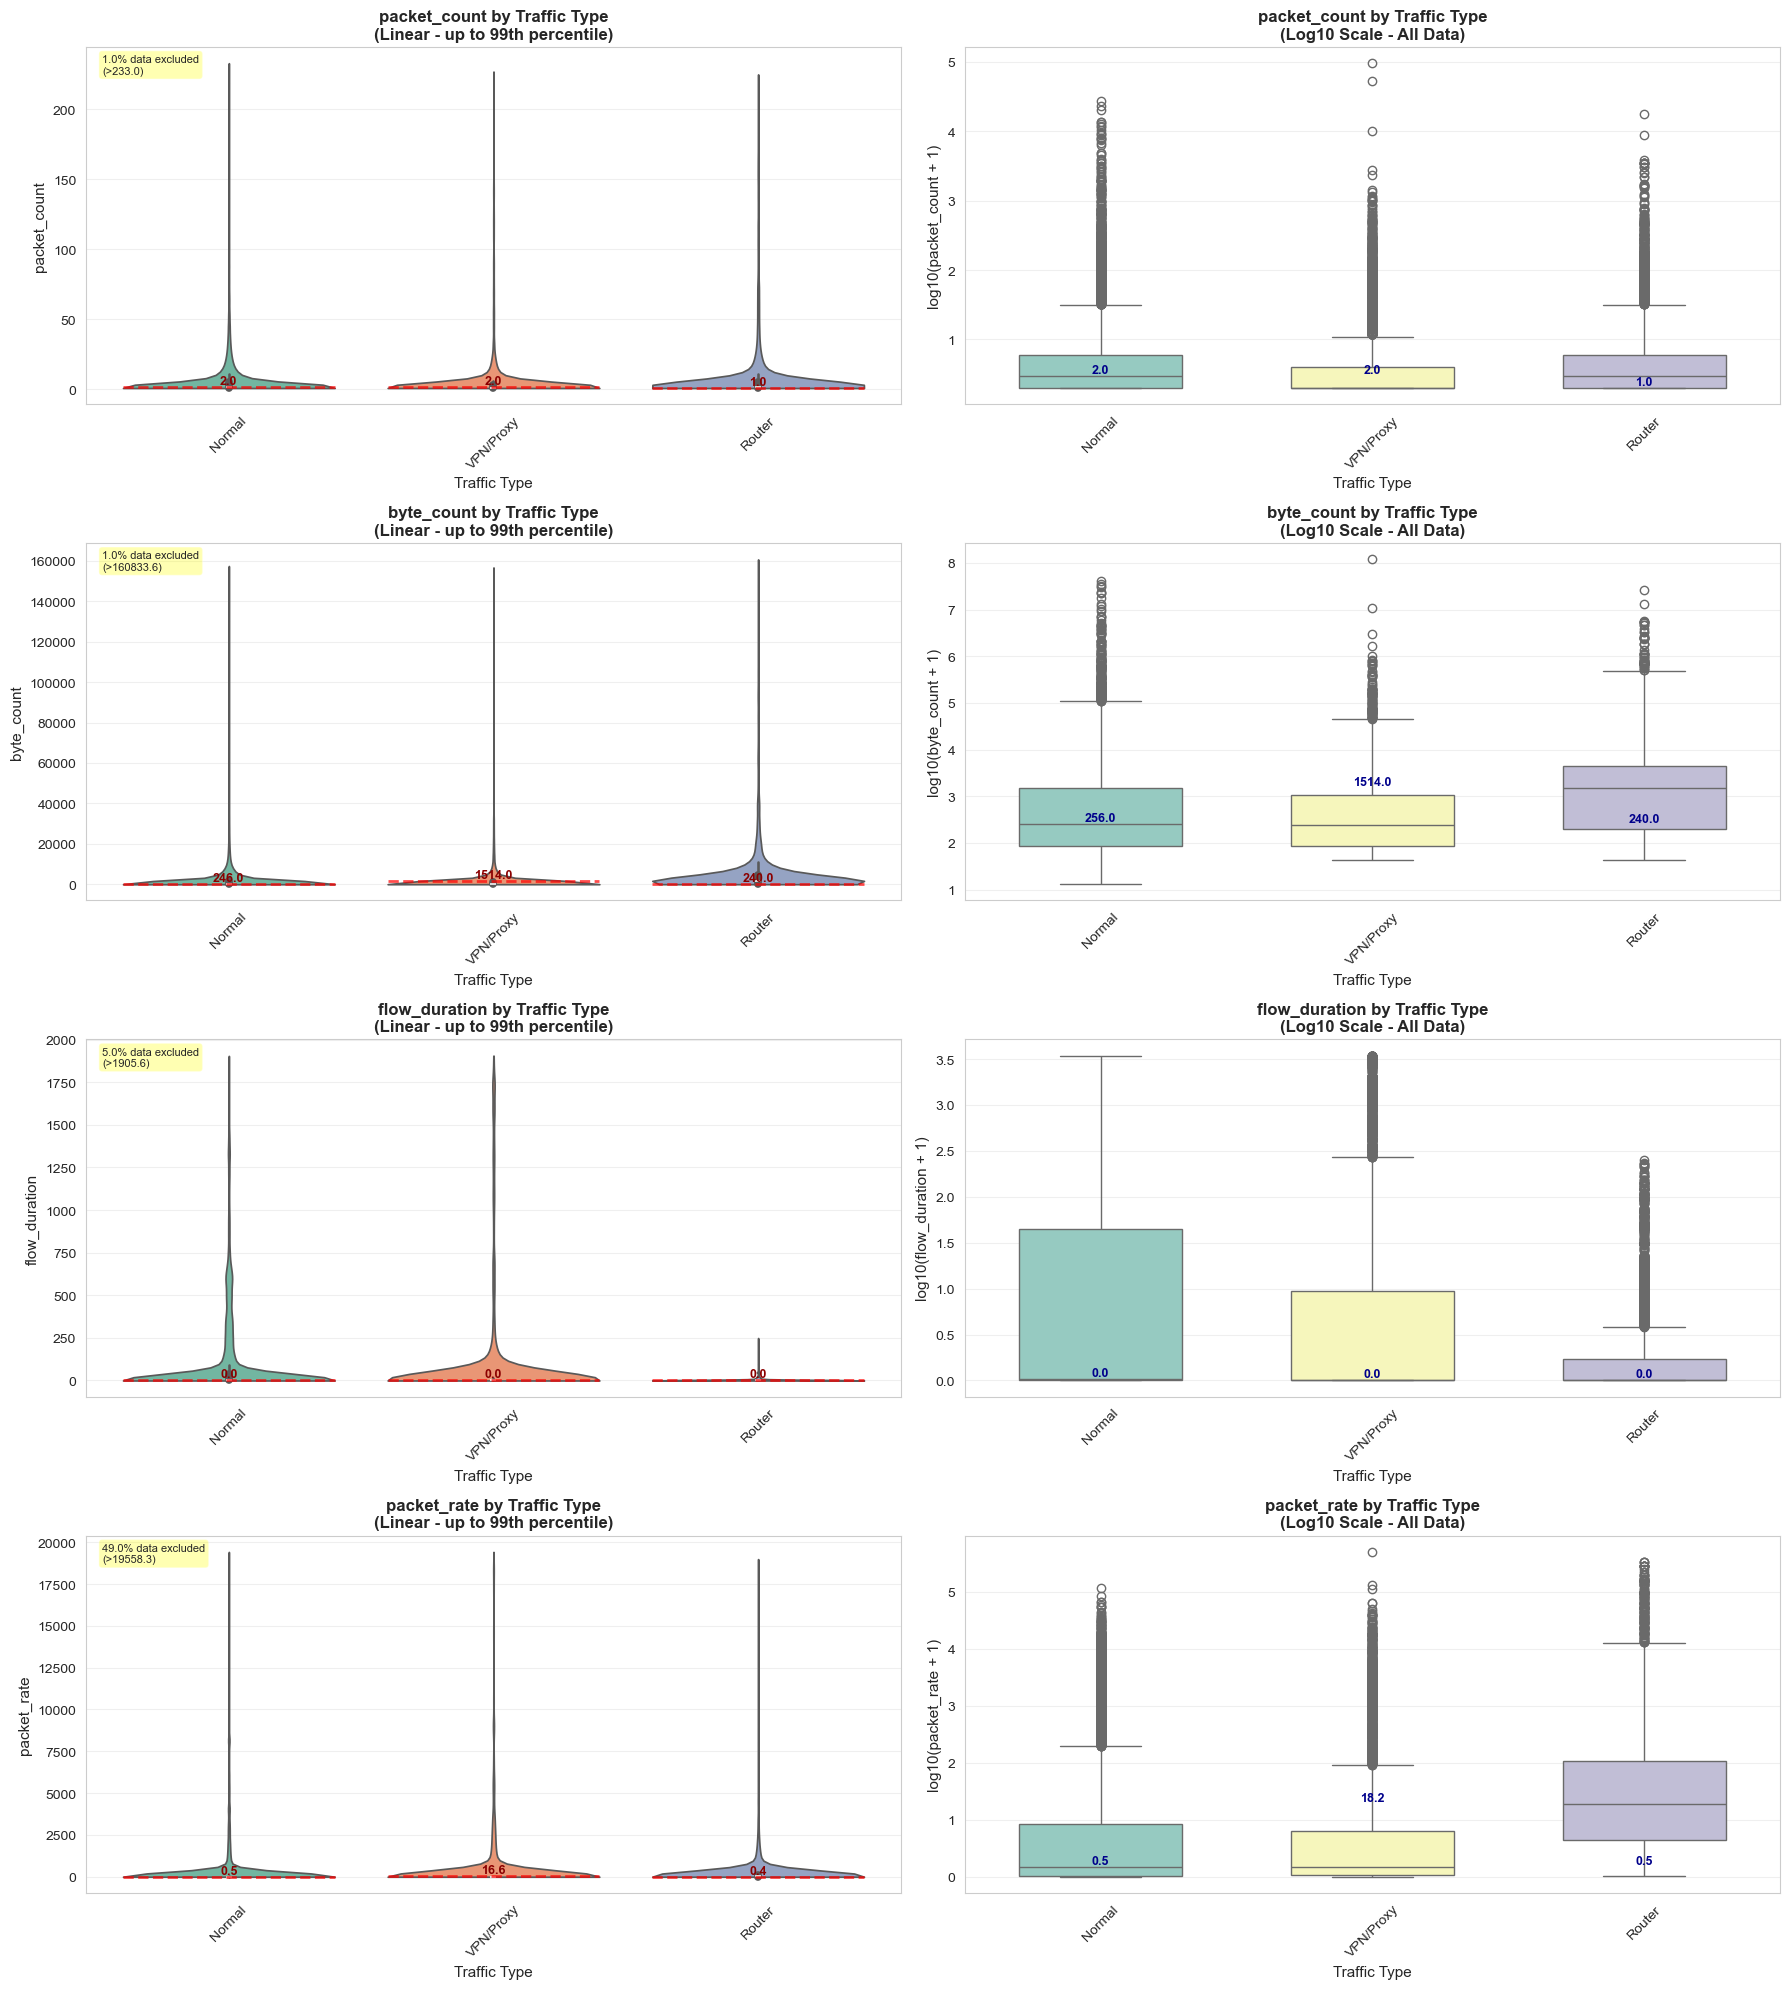


FEATURE STATISTICS BY TRAFFIC TYPE

PACKET_COUNT
           count       mean  median          std  min  25%  75%    95%     99%    max
type                                                                                 
Normal     21305  25.389064     2.0   407.682027    1  1.0  5.0  34.00  233.96  27324
Router      6818  25.535201     2.0   285.728177    1  1.0  5.0  59.15  362.83  17490
VPN/Proxy  10089  25.945188     1.0  1095.883648    1  1.0  3.0  23.00  191.24  95702

Coefficient of Variation (CV = std/mean):
  Normal: 16.06
  VPN/Proxy: 42.24
  Router: 11.19
  None: nan

BYTE_COUNT
           count          mean  median           std   min    25%     75%      95%        99%          max
type                                                                                                      
Normal     21305  23615.150059   256.0  6.080940e+05  12.0   86.0  1514.0  10813.6  118818.72   41362820.0
Router      6818  30819.157378  1514.0  4.199142e+05  42.0  198.0  4542.0  43906.

In [14]:
if available_features and 'type' in flow_features.columns:
    # Select top 4 features for visualization
    features_to_plot = available_features[:4]
    
    # Create figure with 2 rows per feature (linear + log scale)
    fig, axes = plt.subplots(len(features_to_plot), 2, figsize=(18, len(features_to_plot)*5))
    if len(features_to_plot) == 1:
        axes = axes.reshape(1, -1)
    
    for idx, feature in enumerate(features_to_plot):
        # Filter to 99th percentile for better visualization
        q99 = flow_features[feature].quantile(0.99)
        data_filtered = flow_features[flow_features[feature] <= q99]
        
        # LEFT: Violin plot with filtered data (linear scale)
        sns.violinplot(data=data_filtered, x='type', y=feature, ax=axes[idx, 0], 
                      palette='Set2', inner='box', cut=0)
        axes[idx, 0].set_title(f'{feature} by Traffic Type\n(Linear - up to 99th percentile)', 
                              fontsize=12, fontweight='bold')
        axes[idx, 0].set_xlabel('Traffic Type', fontsize=11)
        axes[idx, 0].set_ylabel(feature, fontsize=11)
        axes[idx, 0].tick_params(axis='x', rotation=45)
        axes[idx, 0].grid(True, alpha=0.3, axis='y')
        
        # Add median values as horizontal lines
        medians = data_filtered.groupby('type')[feature].median()
        for i, (traffic_type, median) in enumerate(medians.items()):
            axes[idx, 0].hlines(median, i-0.4, i+0.4, colors='red', 
                               linestyles='--', linewidth=2, alpha=0.7)
            axes[idx, 0].text(i, median, f'{median:.1f}', 
                             ha='center', va='bottom', fontweight='bold', 
                             fontsize=9, color='darkred')
        
        # Add excluded data percentage
        pct_excluded = ((len(flow_features) - len(data_filtered)) / len(flow_features)) * 100
        axes[idx, 0].text(0.02, 0.98, f'{pct_excluded:.1f}% data excluded\n(>{q99:.1f})',
                         transform=axes[idx, 0].transAxes, va='top',
                         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3),
                         fontsize=8)
        
        # RIGHT: Box plot with log scale (all data)
        # Create log-transformed data
        data_log = flow_features.copy()
        data_log[f'{feature}_log'] = np.log10(data_log[feature] + 1)
        
        sns.boxplot(data=data_log, x='type', y=f'{feature}_log', ax=axes[idx, 1], 
                   palette='Set3', width=0.6)
        axes[idx, 1].set_title(f'{feature} by Traffic Type\n(Log10 Scale - All Data)', 
                              fontsize=12, fontweight='bold')
        axes[idx, 1].set_xlabel('Traffic Type', fontsize=11)
        axes[idx, 1].set_ylabel(f'log10({feature} + 1)', fontsize=11)
        axes[idx, 1].tick_params(axis='x', rotation=45)
        axes[idx, 1].grid(True, alpha=0.3, axis='y')
        
        # Add median values
        medians_log = data_log.groupby('type')[f'{feature}_log'].median()
        for i, (traffic_type, median) in enumerate(medians_log.items()):
            # Convert back to original scale for display
            orig_median = flow_features[flow_features['type'] == traffic_type][feature].median()
            axes[idx, 1].text(i, median, f'{orig_median:.1f}', 
                             ha='center', va='bottom', fontweight='bold', 
                             fontsize=9, color='darkblue')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical comparison
    print("\n" + "="*80)
    print("FEATURE STATISTICS BY TRAFFIC TYPE")
    print("="*80)
    for feature in features_to_plot:
        print(f"\n{'='*80}")
        print(f"{feature.upper()}")
        print(f"{'='*80}")
        summary = flow_features.groupby('type')[feature].agg([
            ('count', 'count'),
            ('mean', 'mean'),
            ('median', 'median'),
            ('std', 'std'),
            ('min', 'min'),
            ('25%', lambda x: x.quantile(0.25)),
            ('75%', lambda x: x.quantile(0.75)),
            ('95%', lambda x: x.quantile(0.95)),
            ('99%', lambda x: x.quantile(0.99)),
            ('max', 'max')
        ])
        print(summary.to_string())
        
        # Calculate coefficient of variation for each type
        print("\nCoefficient of Variation (CV = std/mean):")
        for traffic_type in flow_features['type'].unique():
            data = flow_features[flow_features['type'] == traffic_type][feature]
            cv = data.std() / data.mean() if data.mean() != 0 else np.inf
            print(f"  {traffic_type}: {cv:.2f}")
else:
    print("Required columns not found")

## 3.7. Protocol Distribution Analysis

Understanding which protocols are used in different traffic types.

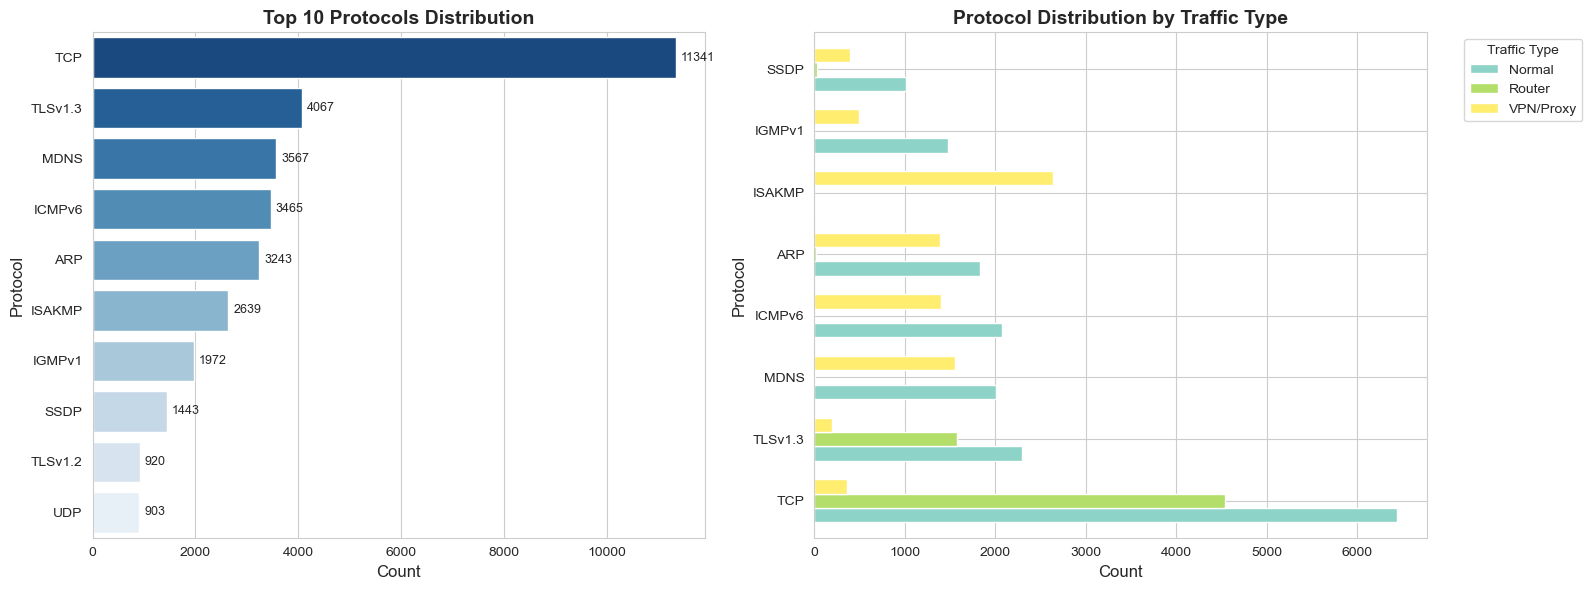


Total unique protocols: 108

Top 10 protocols:
protocol
TCP        11341
TLSv1.3     4067
MDNS        3567
ICMPv6      3465
ARP         3243
ISAKMP      2639
IGMPv1      1972
SSDP        1443
TLSv1.2      920
UDP          903
Name: count, dtype: int64


In [15]:
# Protocol distribution
if 'protocol' in flow_features.columns or 'Protocol' in flow_features.columns:
    protocol_col = 'protocol' if 'protocol' in flow_features.columns else 'Protocol'
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Overall protocol distribution
    protocol_counts = flow_features[protocol_col].value_counts().head(10)
    sns.barplot(x=protocol_counts.values, y=protocol_counts.index, 
               palette='Blues_r', ax=axes[0])
    axes[0].set_title('Top 10 Protocols Distribution', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Count', fontsize=12)
    axes[0].set_ylabel('Protocol', fontsize=12)
    
    # Add value labels
    for i, v in enumerate(protocol_counts.values):
        axes[0].text(v + 100, i, str(v), va='center', fontsize=9)
    
    # Protocol by traffic type (if type column exists)
    if 'type' in flow_features.columns:
        protocol_type_df = pd.crosstab(flow_features[protocol_col], flow_features['type'])
        top_protocols = flow_features[protocol_col].value_counts().head(8).index
        protocol_type_df_top = protocol_type_df.loc[top_protocols]
        
        protocol_type_df_top.plot(kind='barh', stacked=False, ax=axes[1], 
                                  colormap='Set3', width=0.7)
        axes[1].set_title('Protocol Distribution by Traffic Type', 
                         fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Count', fontsize=12)
        axes[1].set_ylabel('Protocol', fontsize=12)
        axes[1].legend(title='Traffic Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTotal unique protocols: {flow_features[protocol_col].nunique()}")
    print(f"\nTop 10 protocols:\n{protocol_counts}")

### Filling in missing values 

In [16]:
flow_features.dropna(subset=['src_ip'], inplace=True)
flow_features.drop("flow_id", axis=1, inplace=True)
flow_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38212 entries, 0 to 38211
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   src_ip           38212 non-null  object 
 1   dst_ip           38212 non-null  object 
 2   protocol         38212 non-null  object 
 3   src_port         33898 non-null  float64
 4   dst_port         33898 non-null  float64
 5   packet_count     38212 non-null  int64  
 6   byte_count       38212 non-null  float64
 7   avg_packet_len   38212 non-null  float64
 8   std_packet_len   20835 non-null  float64
 9   min_packet_len   38212 non-null  float64
 10  max_packet_len   38212 non-null  float64
 11  first_ts         38212 non-null  float64
 12  last_ts          38212 non-null  float64
 13  syn_count        38212 non-null  float64
 14  ack_count        38212 non-null  float64
 15  fin_count        38212 non-null  float64
 16  rst_count        38212 non-null  float64
 17  psh_count        

In [17]:
top_values = flow_features['protocol'].value_counts().nlargest(25).index.tolist()
mapping_dict = {val: i+1 for i, val in enumerate(top_values)}

def category_mapping(data):
    mapping = {
        'type': {'Normal': 0, 'Router': 1, 'VPN/Proxy':2}, 
        'protocol' : mapping_dict
    } 
  
    for feature, value in mapping.items():
        data[feature] = data[feature].map(value).fillna(0).astype(int)

    return data

data = category_mapping(flow_features)

In [18]:
X = flow_features.drop(columns='type')
y = flow_features['type'].astype(int)

import ipaddress

def ip_to_int128(ip_str: str) -> int:
    try:
        return int(ipaddress.ip_address(ip_str))
    except:
        return 0

X["src_ip"] = X["src_ip"].apply(ip_to_int128)
X["dst_ip"] = X["dst_ip"].apply(ip_to_int128)

In [19]:
from sklearn.impute import KNNImputer

def knn_impute_df(df, n_neighbors=3, weights="uniform"):
    """
    Fill NaN values in a pandas DataFrame using KNNImputer.

    Parameters
    df : Input DataFrame with possible NaN values.
    n_neighbors : Number of neighboring samples to use for imputation.
    weights : {'uniform', 'distance'} or callable, default='uniform'. Weight function used in prediction (as in sklearn.KNNImputer).

    Returns
    pandas.DataFrame : DataFrame with NaN values imputed.
    """

    imputer = KNNImputer(n_neighbors=n_neighbors, weights=weights)  
    imputed_array = imputer.fit_transform(df)  
    imputed_df = pd.DataFrame(imputed_array, columns=df.columns, index=df.index)  
    return imputed_df
 
X = knn_impute_df(X)

In [20]:
from sklearn.preprocessing import StandardScaler

def normalize_data(data):
    
    scaler = StandardScaler()
    data[:] = scaler.fit_transform(data)

    return data

X = normalize_data(X)

---
# 4. Model Training & Comparison

Training and comparing multiple machine learning classifiers for traffic classification.

In [21]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

classifiers = [RandomForestClassifier, DecisionTreeClassifier, SVC, LogisticRegression, KNeighborsClassifier, GaussianNB]
classifiers_names = ['RandomForestClassifier', 'DecisionTreeClassifier', 'SVC', 'LogisticRegression', 'KNeighborsClassifier', 'GaussianNB']
classifiers_scores = []

for classifier, name in zip(classifiers, classifiers_names):
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    model = classifier()
    cv_score = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
    classifiers_scores.append(cv_score.mean())


classifiers_df = pd.DataFrame({'Classifier': classifiers_names, 'Score': classifiers_scores})
classifiers_df

,Classifier,Score
0,RandomForestClassifier,0.961504
1,DecisionTreeClassifier,0.953575
2,SVC,0.827855
3,LogisticRegression,0.674735
4,KNeighborsClassifier,0.863760
5,GaussianNB,0.709331


In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],           # Split quality measure
    'max_depth': [None, 5, 10, 20, 30],         # Max depth of tree
    'min_samples_split': [1, 2, 5, 8, 10],            # Min samples required to split a node
    'min_samples_leaf': [1, 2, 4, 8]               # Min samples required at a leaf node
}

grid_search = GridSearchCV(
    estimator=dt_classifier,
    param_grid=param_grid,
    cv=10,
    n_jobs=-1,
    scoring='accuracy' 
)

grid_search.fit(X, y)


print(f"Best Accuracy: {grid_search.best_score_:.4f}")
print(f"Best Parameters: {grid_search.best_params_}")

best_model = grid_search.best_estimator_

Best Accuracy: 0.9413
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],      # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],      # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],      # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],        # Minimum samples required to be at a leaf node
    'bootstrap': [True, False]            # Method for sampling data points (with or without replacement)
}

grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=10,
    n_jobs=-1,
    scoring='accuracy',
    verbose=1
)

grid_search_rf.fit(X, y)

print(f"Best Accuracy: {grid_search_rf.best_score_:.4f}")
print("Best Parameters:")
print(grid_search_rf.best_params_)

best_rf_model = grid_search_rf.best_estimator_


Fitting 10 folds for each of 216 candidates, totalling 2160 fits
Best Accuracy: 0.9422
Best Parameters:
{'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}


## 5. Model Performance Visualization

Visual analysis of model predictions and performance metrics.

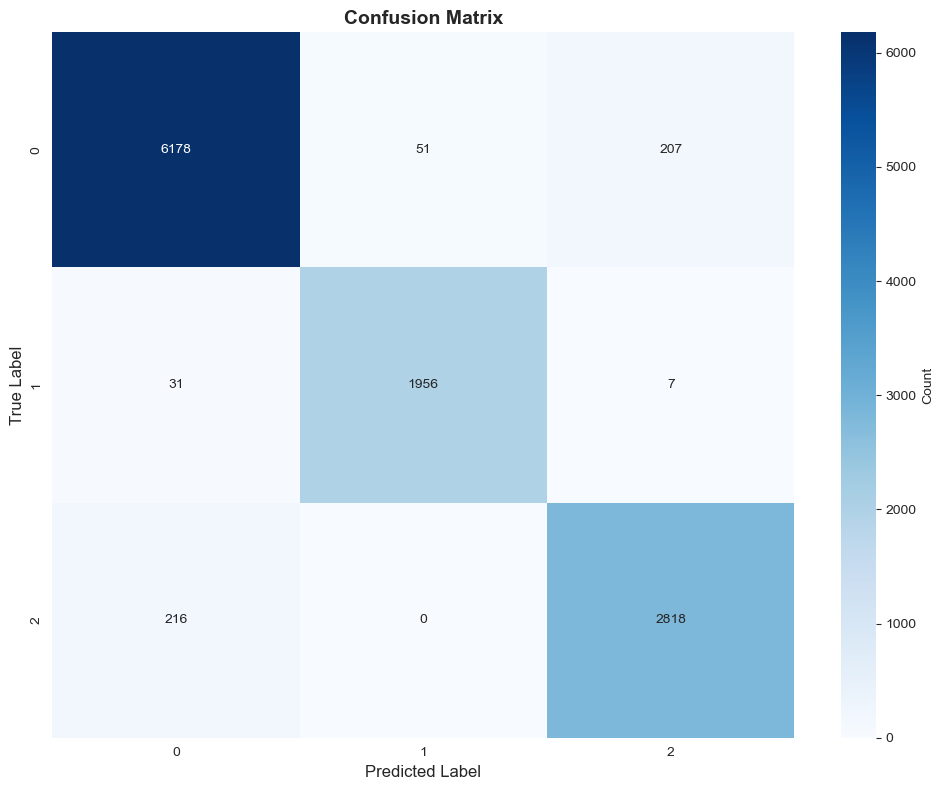

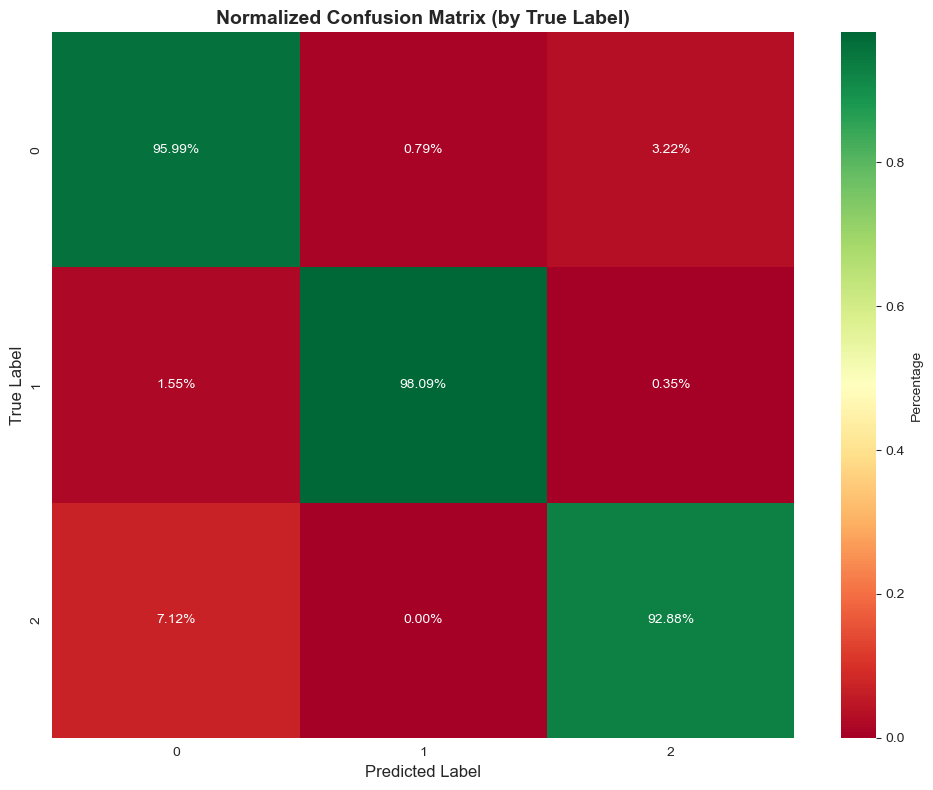


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      6436
           1       0.97      0.98      0.98      1994
           2       0.93      0.93      0.93      3034

    accuracy                           0.96     11464
   macro avg       0.96      0.96      0.96     11464
weighted avg       0.96      0.96      0.96     11464



In [26]:
# Confusion Matrix Visualization
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

clf = best_model.fit(X_train, y_train)

y_pred = clf.predict(X_test)

try:
    cm = confusion_matrix(y_test, y_pred)
        
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.unique(y_test), 
                yticklabels=np.unique(y_test),
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Normalized confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn',
                xticklabels=np.unique(y_test),
                yticklabels=np.unique(y_test),
                cbar_kws={'label': 'Percentage'})
    plt.title('Normalized Confusion Matrix (by True Label)', 
                fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.show()
        
    # Classification report
    print("\nClassification Report:")
    print("="*60)
    print(classification_report(y_test, y_pred))
except Exception as e:
    print(f"Could not generate confusion matrix: {e}")
    print("This cell requires y_test and y_pred variables from model evaluation")

## Saving the Model locally
This local file can be used to generate predictions without having to retrain our models allowing easier compatability with web servers and reducing time needed for classification.

In [27]:
clf=best_model.fit(X,y)

import joblib

joblib.dump(clf, "C:/Users/aakas/Downloads/traffic_model.joblib")

['C:/Users/aakas/Downloads/traffic_model.joblib']